In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy.stats import entropy
import networkit as nk #more efficient
import pickle

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins,is_day,time_series_henColumn_tsRow, is_WG_open, is_day
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [163]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_tracking_date = config.li_tracking_date
print(id_run)
path_extracted_data_visual = os.path.join(path_extracted_data,'visual','3Dspace')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual):
    os.makedirs(path_extracted_data_visual)

change the configuration file if not done yet!
EXP2_


In [ ]:
#with weight on the edge: TODO AND READ
#https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-weighted-node-classification.html

# Download data

In [4]:
df_dailyvar = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';', parse_dates=['level'],
                dayfirst=True) 
df_h = df_dailyvar.groupby('HenID')['CorrectPenID'].agg(lambda x: list(set(x))).reset_index()
df_h['nbrR'] = df_h['CorrectPenID'].map(lambda x: len(x))
display(df_h['nbrR'].value_counts())
df_h['Relocated'] = df_h['nbrR'].map(lambda x: x!=1)
dico_henid_isrel = dict(zip(df_h['HenID'].tolist(), df_h['Relocated'].tolist()))
#dico_henid_isrel
print(df_dailyvar.shape)
df_dailyvar.head(3)

1    85
4    78
2     3
3     3
Name: nbrR, dtype: int64

(7597, 44)


,HenID,level,perc_duration_3_Zone,perc_duration_2_Zone,perc_duration_4_Zone,perc_duration_5_Zone,Total_number_zone,mid_cum_Z4_sec,Total_number_transition,vertical_travel_distance,...,HenID_Period,HenID_date,system,CorrectPenID,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday
0,hen_1,2021-10-09,12.0,88.0,0.0,0.0,2.0,NaN,6.0,6.0,...,hen_1_early,hen_1-2021-10-09,10-12,pen10,NaN,473.583333,66.416667,0.000000,0.0,False
1,hen_1,2021-10-10,28.0,68.0,4.0,0.0,3.0,13346.0,14.0,14.0,...,hen_1_early,hen_1-2021-10-10,10-12,pen10,NaN,364.683333,153.033333,22.283333,0.0,False
2,hen_1,2021-10-16,15.0,85.0,0.0,0.0,2.0,NaN,6.0,6.0,...,hen_1_early,hen_1-2021-10-16,10-12,pen10,NaN,459.133333,80.866667,0.000000,0.0,False


In [5]:
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp', 'date'],
                dayfirst=True) 
print(df.shape)
df.head(3)

(2099229, 23)


,Unnamed: 0,Timestamp,HenID,Zone,PenID,ts_order,TagID,signalstrength,system,time,...,zone3,zone4,next_record_date,duration,next_zone,previous_zone,is_dur_smaller_60sec,correction_is_consecutive_equal_initial_zone,is_WG_open,is_day
0,132,2021-10-08 00:24:41,hen_1,3_Zone,pen10,348506,tag_5,14,10 - 12,00:24:41,...,6,0,2021-10-08 10:59:30,38089.0,2_Zone,NaN,False,False,False,False
1,1274,2021-10-08 10:59:30,hen_1,2_Zone,pen10,348747,tag_5,5,10 - 12,10:59:30,...,0,0,2021-10-09 10:33:27,84837.0,2_Zone,3_Zone,False,False,False,True
2,6916,2021-10-09 10:33:27,hen_1,3_Zone,pen10,350158,tag_5,15,10 - 12,10:33:27,...,4,6,2021-10-09 10:59:56,1589.0,3_Zone,2_Zone,False,False,False,True


In [6]:
df_dailyvar['Period_type'].value_counts()

R3       2452
R2       1923
R1       1314
late     1101
early     807
Name: Period_type, dtype: int64

# Similarities between each day-hen

In [9]:
period_type = 'R1'
li_level = list(pd.date_range(start=dt.datetime(2022,2,1), end=dt.datetime(2022,2,7), freq = 'D'))

In [10]:
#decide on the level of the time serie
nbr_sec = 1
#add previous and last date, een if RFID was on at that time, we will use the first previous and lasst transitions 
#to not loose an entire day
li_add = [min(li_level)-dt.timedelta(days=1), max(li_level)+dt.timedelta(days=1)]
li_level.extend(li_add)
li_level = sorted(li_level)
print()
print(li_level)

df_ = df[df['date'].isin(li_level)].copy()
#sort by timestamp and do pivot
df_ = df_.sort_values(['Timestamp'], ascending=True)
x0 = df_.shape[0]

#No need now to have no duplicate timestamp per hen:
#df = df.groupby(['Timestamp','HenID'])[col_ts].agg(lambda x: list(x)[0]).reset_index()  
df_hens = df_.pivot(index='Timestamp', columns='HenID', values='Zone')

#fill "None" values with the last non-empty value (by propagating last valHenID observation forward to next valHenID)
#In order to fill in between timestamp, ie. timestamp that another hen had, then the other should also have their latest zone 
#entered instead of nan Note that the first ones will stay None
df_hens = df_hens.fillna(method='ffill')
display(df_hens.head(3))

#Warning: not all hens have same initial/enddate!
#add missing dates 
mi = min(df_['Timestamp'].tolist())
ma = max(df_['Timestamp'].tolist())
print('The initial starting date in over all is: %s, and the ending date will be: %s'%(str(mi), str(ma)))
print('But note that birds may have different ending and starting date which should be taken into account when computing variables')

#add dates until minuit of the last day
ma = dt.datetime(ma.year,ma.month,ma.day,23,59,59)
print('and after ending the last day at midnight : %s, and the ending date will be: %s'%(str(mi), str(ma)))
Daterange = pd.date_range(start=mi, end=ma, freq='S') 
#take only the needed values (nbr_sec)
Daterange = [Daterange[i] for i in range(len(Daterange)) if i%nbr_sec==0]
#Daterange[0:10]

#add missing seconds (i.e. all seconds that never had a record) and fillnan with last non-nan values by propagating last 
#valHenID observation (even if its an observation that will be removed) forward to next valHenID
df_hens = df_hens.reindex(Daterange, method='ffill').reset_index()    
df_hens['date'] = df_hens['Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
print(df_hens.shape)
df_hens = df_hens[~df_hens['date'].isin(li_add)]
print(df_hens.shape)
#remove the first and last added date
#df_hens.to_csv(os.path.join(path_extracted_data,id_run+'_TimeSeries'+period_type+'.csv'), sep=';', index=False)

#keep only day-time remove night-time  
df_hens['is_day'] = df_hens['Timestamp'].map(lambda x: is_day(x, config.dico_night_hour))
print(df_hens.shape)
df_hens = df_hens[df_hens['is_day']]
print(df_hens.shape)


[Timestamp('2022-01-31 00:00:00', freq='D'), Timestamp('2022-02-01 00:00:00', freq='D'), Timestamp('2022-02-02 00:00:00', freq='D'), Timestamp('2022-02-03 00:00:00', freq='D'), Timestamp('2022-02-04 00:00:00', freq='D'), Timestamp('2022-02-05 00:00:00', freq='D'), Timestamp('2022-02-06 00:00:00', freq='D'), Timestamp('2022-02-07 00:00:00', freq='D'), Timestamp('2022-02-08 00:00:00', freq='D')]


HenID,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,hen_106,hen_107,...,hen_90,hen_91,hen_92,hen_93,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-31 00:09:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-31 00:20:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-31 00:56:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The initial starting date in over all is: 2022-01-31 00:09:33, and the ending date will be: 2022-02-08 23:17:20
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2022-01-31 00:09:33, and the ending date will be: 2022-02-08 23:59:59
(777027, 170)
(604800, 170)
(604800, 171)
(352800, 171)


In [11]:
df_hens.head(3)

HenID,Timestamp,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,hen_106,...,hen_92,hen_93,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99,date,is_day
96627,2022-02-01 03:00:00,4_Zone,3_Zone,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,3_Zone,5_Zone,...,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,3_Zone,2022-02-01,True
96628,2022-02-01 03:00:01,4_Zone,3_Zone,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,3_Zone,5_Zone,...,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,3_Zone,2022-02-01,True
96629,2022-02-01 03:00:02,4_Zone,3_Zone,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,3_Zone,5_Zone,...,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,5_Zone,3_Zone,2022-02-01,True


In [36]:
li_hen = [i for i in df_hens.columns if 'hen_' in i]
df_ts = df_hens.groupby('date')[li_hen].agg(lambda x: list(x)).reset_index()
print(df_ts.shape)
display(df_ts.head(3))
df_ts = pd.melt(df_ts, id_vars=['date'], value_vars=li_hen, value_name = 'ts')
df_ts['henid_level'] = df_ts.apply(lambda x: x['HenID']+'/'+str(x['date']).split(' ')[0].replace('-',''), axis=1)
dico_henidlevel_ts = dict(zip(df_ts['henid_level'].tolist(), df_ts['ts'].tolist()))
display(df_ts.head(3))

(7, 169)


HenID,date,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,hen_106,...,hen_90,hen_91,hen_92,hen_93,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99
0,2022-02-01,"[4_Zone, 4_Zone, 4_Zone, 4_Zone, 4_Zone, 4_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...",...,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon..."
1,2022-02-02,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[4_Zone, 4_Zone, 4_Zone, 4_Zone, 4_Zone, 4_Zon...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...",...,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon..."
2,2022-02-03,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[4_Zone, 4_Zone, 4_Zone, 4_Zone, 4_Zone, 4_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...",...,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...","[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon..."


,date,HenID,ts,henid_level
0,2022-02-01,hen_1,"[4_Zone, 4_Zone, 4_Zone, 4_Zone, 4_Zone, 4_Zon...",hen_1/20220201
1,2022-02-02,hen_1,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...",hen_1/20220202
2,2022-02-03,hen_1,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zon...",hen_1/20220203


In [37]:
########## compute similarities
dico_hl1hl2_sim = {}
li_henidlevel = df_ts['henid_level'].unique()
for k1 in tqdm.tqdm(range(0,len(li_henidlevel)-1)):
    hl1 = li_henidlevel[k1]
    li1 = dico_henidlevel_ts[hl1]
    if (np.nan not in li1):
        for k2 in range(k1+1,len(li_henidlevel)): 
            hl2 = li_henidlevel[k2]
            li2 = dico_henidlevel_ts[hl2]
            if (np.nan not in li2) & (len(li1)==len(li2)):
                #percentage of seconds in a same zone during the day only
                sim_ = sum(np.array(li1)==np.array(li2))/len(li1)
                hl1hl2 = '-'.join(sorted([hl1,hl2]))
                dico_hl1hl2_sim[hl1hl2] = sim_
#save
pickle.dump(dico_hl1hl2_sim, open(os.path.join(path_extracted_data,'dico_hl1hl2_sim.pkl'), 'wb'), 
            pickle.HIGHEST_PROTOCOL)
#load
#dico_hl1hl2_sim = pickle.load(open(os.path.join(path_extracted_data,'dico_hl1hl2_sim.pkl'), 'rb'))

100%|████████████████████████████████████████████████████████████████████████████| 1175/1175 [6:27:51<00:00, 19.81s/it]


NameError: name 'pickle' is not defined

In [ ]:
#TODO: remove nan

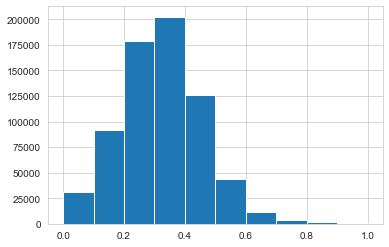

In [41]:
plt.hist(dico_hl1hl2_sim.values())
sim_mean = np.mean(list(dico_hl1hl2_sim.values()))

In [48]:
df_sim = pd.DataFrame.from_dict({'hl1hl2':dico_hl1hl2_sim.keys(), 'sim':dico_hl1hl2_sim.values()})
df_sim['h1'] = df_sim['hl1hl2'].map(lambda x: x.split('/')[0])
df_sim['l1'] = df_sim['hl1hl2'].map(lambda x: x.split('/')[1].split('-')[0])
df_sim['h2'] = df_sim['hl1hl2'].map(lambda x: x.split('-')[1].split('/')[0])
df_sim['l2'] = df_sim['hl1hl2'].map(lambda x: x.split('/')[-1])
df_sim['hl1'] = df_sim['hl1hl2'].map(lambda x: x.split('-')[0])
df_sim['hl2'] = df_sim['hl1hl2'].map(lambda x: x.split('-')[1])
df_sim['samedate'] = df_sim.apply(lambda x: int(x['l1']==x['l2']), axis=1)
df_sim['samehen'] = df_sim.apply(lambda x: int(x['h1']==x['h2']), axis=1)
print(df_sim.shape)
display(df_sim[df_sim['samehen']==0].head(3))
display(df_sim.head(3))

(690900, 10)


,hl1hl2,sim,h1,l1,h2,l2,hl1,hl2,samedate,samehen
6,hen_1/20220201-hen_10/20220201,0.625000,hen_1,20220201,hen_10,20220201,hen_1/20220201,hen_10/20220201,1,0
7,hen_1/20220201-hen_10/20220202,0.549821,hen_1,20220201,hen_10,20220202,hen_1/20220201,hen_10/20220202,0,0
8,hen_1/20220201-hen_10/20220203,0.591885,hen_1,20220201,hen_10,20220203,hen_1/20220201,hen_10/20220203,0,0


,hl1hl2,sim,h1,l1,h2,l2,hl1,hl2,samedate,samehen
0,hen_1/20220201-hen_1/20220202,0.608710,hen_1,20220201,hen_1,20220202,hen_1/20220201,hen_1/20220202,0,1
1,hen_1/20220201-hen_1/20220203,0.621687,hen_1,20220201,hen_1,20220203,hen_1/20220201,hen_1/20220203,0,1
2,hen_1/20220201-hen_1/20220204,0.585833,hen_1,20220201,hen_1,20220204,hen_1/20220201,hen_1/20220204,0,1


# One graph over consistent similarities

0    592704
1     98196
Name: samedate, dtype: int64

,h1,h2,sim,sim_mean,sim_percabovemean
0,hen_1,hen_10,"[0.625, 0.5112103174603174, 0.4809126984126984...",0.565037,1.0
1,hen_1,hen_100,"[0.5711706349206349, 0.3529761904761905, 0.447...",0.503716,1.0
2,hen_1,hen_101,"[0.04416666666666667, 0.22126984126984128, 0.1...",0.161077,0.0


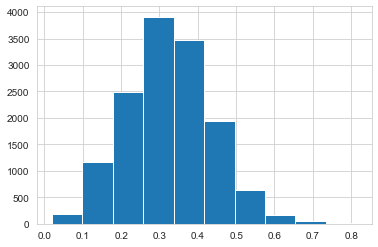

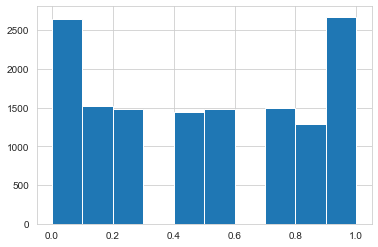

In [62]:
display(df_sim['samedate'].value_counts())
df_simtot = df_sim[df_sim['samedate']==1].copy()
df_simtot = df_simtot.groupby(['h1','h2'])['sim'].agg(lambda x: list(x)).reset_index()
df_simtot['sim_mean'] = df_simtot['sim'].map(lambda x: np.mean(x))
df_simtot['sim_percabovemean'] = df_simtot['sim'].map(lambda x: sum([i>sim_mean for i in x])/len(x))
display(df_simtot.head(3))
plt.hist(df_simtot['sim_mean'])
plt.show()
plt.hist(df_simtot['sim_percabovemean'])
plt.show()

In [68]:
min_sim = 0.5 
df_gr = df_simtot[df_simtot['sim_percabovemean']>min_sim].copy()
display(df_gr.head(3))
#define a unique matching between henid and graph's node ids
li_hen_level = list(set(df_gr['h1'].tolist()+df_gr['h2'].tolist()))
G_CS = nk.Graph(len(li_hen_level), directed=False, weighted=True)
dico_henid_graphid = dict(zip(li_hen_level, list(range(0,len(li_hen_level)))))
for i in tqdm.tqdm(range(0,df_gr.shape[0])):
    x = df_gr.iloc[i]
    h1 = x['h1'] ; h2 = x['h2'] ; sim_ = x['sim_mean']
    G_CS.addEdge(dico_henid_graphid[h1], dico_henid_graphid[h2], w=sim_) 
print(G_CS.numberOfEdges(), G_CS.numberOfNodes())

,h1,h2,sim,sim_mean,sim_percabovemean
0,hen_1,hen_10,"[0.625, 0.5112103174603174, 0.4809126984126984...",0.565037,1.0
1,hen_1,hen_100,"[0.5711706349206349, 0.3529761904761905, 0.447...",0.503716,1.0
4,hen_1,hen_103,"[0.4672222222222222, 0.5028968253968253, 0.402...",0.505374,1.0


100%|███████████████████████████████████████████████████████████████████████████| 6933/6933 [00:00<00:00, 12525.27it/s]

6933 167


(167, 7)


,d1,d2,d3,graphID,HenID,color,Relocated
0,2.891667,7.106194,4.756445,0,hen_103,black,1
1,0.124704,2.673028,3.857832,1,hen_48,black,0
2,1.183708,3.358046,3.038990,2,hen_87,black,1


C:\Users\camil\AppData\Local\Temp/ipykernel_12008/3156563781.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)
C:\Users\camil\AppData\Local\Temp/ipykernel_12008/3156563781.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5);


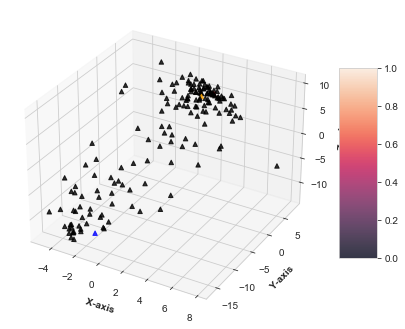

In [80]:
#https://networkit.github.io/dev-docs/python_api/embedding.html
cc = nk.embedding.Node2Vec(G=G_CS, P=1.1, Q=0.9, L=10, N=10000, D=3)
cc.run() #compute all node embedding
res = cc.getFeatures()
x = np.array([res[i][0] for i in range(0,len(res))])
y = np.array([res[i][1] for i in range(0,len(res))])
z = np.array([res[i][2] for i in range(0,len(res))])

df_3dspace = pd.DataFrame.from_dict({'d1':x, 'd2':y, 'd3':z,
                                     'graphID':dico_henid_graphid.values(),
                                     'HenID':dico_henid_graphid.keys()})
dico_hensel_color = {'hen_112':'red', 'hen_15':'orange', 'hen_81':'blue'}
df_3dspace['color'] = df_3dspace['HenID'].map(lambda x: dico_hensel_color.get(x,'black'))
df_3dspace['Relocated'] = df_3dspace['HenID'].map(lambda x: int(dico_henid_isrel[x]))
print(df_3dspace.shape)
display(df_3dspace.head(3))

# Creating figure
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)
# Creating color map
my_cmap = plt.get_cmap('hsv')
# Creating plot
sctt = ax.scatter3D(x, y, z, alpha = 0.8, marker ='^', c=df_3dspace['color'].tolist())
#my_cmap = plt.get_cmap('hsv')
#c = (x + y + z),cmap = my_cmap,
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
#ax.text3D(x, y, z, list(dico_henid_graphid.keys()))
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5);

In [ ]:
#now we want to compare this graph with the same but after the relocaion

# One graph with all day-hen

In [83]:
min_sim = np.mean(df_sim['sim'])
df_gr = df_sim[df_sim['sim']>min_sim].copy()
#define a unique matching between henid and graph's node ids
li_hen_level = list(set(df_gr['hl1'].tolist()+df_gr['hl2'].tolist())) #check
dico_henid_graphid = dict(zip(li_hen_level, list(range(0,len(li_hen_level)))))
G_FDH = nk.Graph(len(li_hen_level), directed=False, weighted=True)
for i in tqdm.tqdm(range(0,df_gr.shape[0])):
    x = df_gr.iloc[i]
    h1 = x['hl1'] ; h2 = x['hl2'] ; sim_ = x['sim']
    G_FDH.addEdge(dico_henid_graphid[h1], dico_henid_graphid[h2], w=sim_) 
print(G_FDH.numberOfEdges(), G_FDH.numberOfNodes())

100%|███████████████████████████████████████████████████████████████████████| 339046/339046 [00:29<00:00, 11355.41it/s]

339046 1176


(1176, 8)


,d1,d2,d3,graphID,HenID,color,h,Relocated
0,-5.175012,5.671566,-4.215130,0,hen_117/20220204,blue,hen_117,1
1,-5.240068,6.006335,-3.412030,1,hen_146/20220202,black,hen_146,0
2,-3.385747,4.154411,-2.178938,2,hen_108/20220207,black,hen_108,1


C:\Users\camil\AppData\Local\Temp/ipykernel_12008/1811678618.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)
C:\Users\camil\AppData\Local\Temp/ipykernel_12008/1811678618.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5);


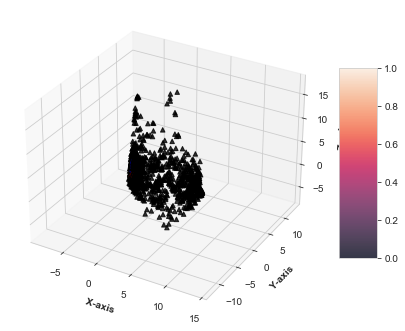

In [89]:
# 3D embedding so that each hens get one same color fr each days
#https://networkit.github.io/dev-docs/python_api/embedding.html
cc = nk.embedding.Node2Vec(G=G_FDH, P=1.1, Q=0.9, L=10, N=10000, D=3)
cc.run() #compute all node embedding
res = cc.getFeatures()
x = np.array([res[i][0] for i in range(0,len(res))])
y = np.array([res[i][1] for i in range(0,len(res))])
z = np.array([res[i][2] for i in range(0,len(res))])

df_3dspace = pd.DataFrame.from_dict({'d1':x, 'd2':y, 'd3':z,
                                     'graphID':dico_henid_graphid.values(),
                                     'HenID':dico_henid_graphid.keys()})
dico_hensel_color = {k:'red' for k in dico_henid_graphid.keys() if 'hen_112' in k} #TODO
for k in dico_henid_graphid.keys():
    if 'hen_117' in k:
        dico_hensel_color[k]='blue'
df_3dspace['color'] = df_3dspace['HenID'].map(lambda x: dico_hensel_color.get(x,'black'))
df_3dspace['h'] = df_3dspace['HenID'].map(lambda x: x.split('/')[0])
df_3dspace['Relocated'] = df_3dspace['h'].map(lambda x: int(dico_henid_isrel[x]))
print(df_3dspace.shape)
display(df_3dspace.head(3))

# Creating figure
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)
# Creating color map
my_cmap = plt.get_cmap('hsv')
# Creating plot
sctt = ax.scatter3D(x, y, z, alpha = 0.8, marker ='^', c=df_3dspace['color'].tolist())
#my_cmap = plt.get_cmap('hsv')
#c = (x + y + z),cmap = my_cmap,
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
#ax.text3D(x, y, z, list(dico_henid_graphid.keys()))
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5);

(1176, 9)


,d1,d2,d3,graphID,HenID,color,size,h,Relocated
0,-5.175012,5.671566,-4.215130,0,hen_117/20220204,blue,30,hen_117,1
1,-5.240068,6.006335,-3.412030,1,hen_146/20220202,green,30,hen_146,0
2,-3.385747,4.154411,-2.178938,2,hen_108/20220207,white,5,hen_108,1


C:\Users\camil\AppData\Local\Temp/ipykernel_12008/1767110098.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)


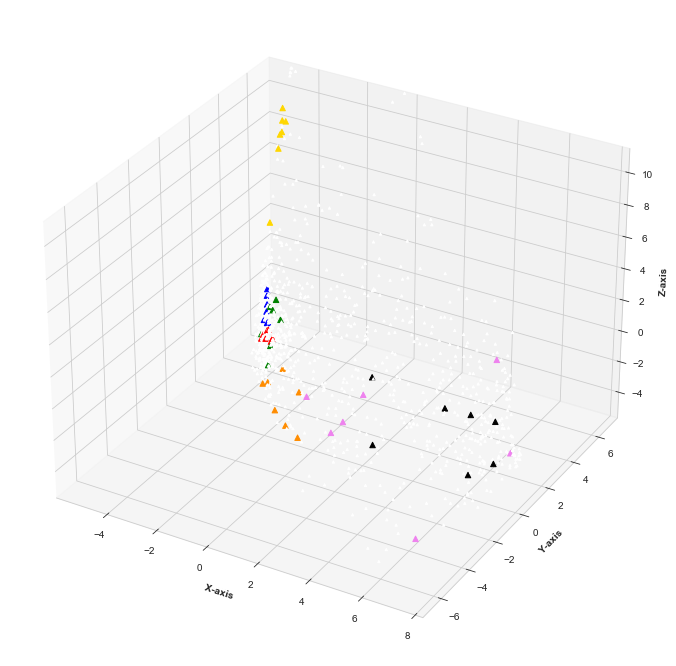

In [219]:
x = np.array([res[i][0] for i in range(0,len(res))])
y = np.array([res[i][1] for i in range(0,len(res))])
z = np.array([res[i][2] for i in range(0,len(res))])

df_3dspace = pd.DataFrame.from_dict({'d1':x, 'd2':y, 'd3':z,
                                     'graphID':dico_henid_graphid.values(),
                                     'HenID':dico_henid_graphid.keys()})
dico_hensel_color = {}
li_vis_hen = ['hen_112','hen_117', 'hen_146', 'hen_149', 'hen_151', 'hen_145','hen_125']
li_vis_col = ['red','blue','green','black','darkorange','violet','gold'] #cornflowerblue
for h,c in zip(li_vis_hen,li_vis_col):
    for k in dico_henid_graphid.keys():
        if h+'/' in k:
            dico_hensel_color[k] = c
df_3dspace['color'] = df_3dspace['HenID'].map(lambda x: dico_hensel_color.get(x,'white'))
df_3dspace['size'] = df_3dspace['color'].map(lambda x: 30 if x!='white' else 5)
df_3dspace['h'] = df_3dspace['HenID'].map(lambda x: x.split('/')[0])
df_3dspace['Relocated'] = df_3dspace['h'].map(lambda x: int(dico_henid_isrel[x]))
print(df_3dspace.shape)
display(df_3dspace.head(3))
# Creating figure
fig = plt.figure(figsize = (12, 12))
ax = plt.axes(projection ="3d")
# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)
# Creating color map
my_cmap = plt.get_cmap('hsv')
# Creating plot
ax.scatter3D(x, y, z,s=df_3dspace['size'].tolist(), alpha = 1, marker ='^', c=df_3dspace['color'].tolist())
#my_cmap = plt.get_cmap('hsv')
#c = (x + y + z),cmap = my_cmap,
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_xlim((min(x),max(x)))
ax.set_ylim((min(y),max(y)))
ax.set_zlim((min(z),max(z)))
ax.set_xlim((np.percentile(x,10),8))
ax.set_ylim((-7,np.percentile(y,95)))
ax.set_zlim((np.percentile(z,10),np.percentile(z,95)))
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
#ax.text3D(x, y, z, list(dico_henid_graphid.keys()))
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5);
plt.savefig(os.path.join(path_extracted_data_visual,'3DspaceV1.png'), format='png', bbox_inches='tight', dpi=300)

(1176, 9)


,d1,d2,d3,graphID,HenID,color,size,h,Relocated
0,-5.175012,5.671566,-4.215130,0,hen_117/20220204,blue,30,hen_117,1
1,-5.240068,6.006335,-3.412030,1,hen_146/20220202,green,30,hen_146,0
2,-3.385747,4.154411,-2.178938,2,hen_108/20220207,white,5,hen_108,1


C:\Users\camil\AppData\Local\Temp/ipykernel_12008/2935524762.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)


ValueError: s must be a scalar, or float array-like with the same size as x and y

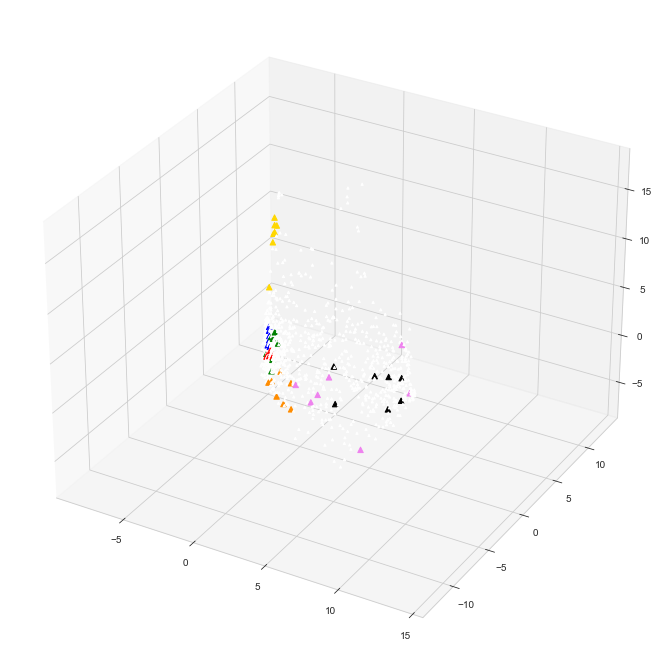

In [225]:
x = np.array([res[i][0] for i in range(0,len(res))])
y = np.array([res[i][1] for i in range(0,len(res))])
z = np.array([res[i][2] for i in range(0,len(res))])

df_3dspace = pd.DataFrame.from_dict({'d1':x, 'd2':y, 'd3':z,
                                     'graphID':dico_henid_graphid.values(),
                                     'HenID':dico_henid_graphid.keys()})
dico_hensel_color = {}
li_vis_hen = ['hen_112','hen_117', 'hen_146', 'hen_149', 'hen_151', 'hen_145','hen_125']
li_vis_col = ['red','blue','green','black','darkorange','violet','gold'] #cornflowerblue
for h,c in zip(li_vis_hen,li_vis_col):
    for k in dico_henid_graphid.keys():
        if h+'/' in k:
            dico_hensel_color[k] = c
df_3dspace['color'] = df_3dspace['HenID'].map(lambda x: dico_hensel_color.get(x,'white'))
df_3dspace['size'] = df_3dspace['color'].map(lambda x: 30 if x!='white' else 5)
df_3dspace['h'] = df_3dspace['HenID'].map(lambda x: x.split('/')[0])
df_3dspace['Relocated'] = df_3dspace['h'].map(lambda x: int(dico_henid_isrel[x]))
print(df_3dspace.shape)
display(df_3dspace.head(3))
# Creating figure
fig = plt.figure(figsize = (12, 12))
ax = plt.axes(projection ="3d")
# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2)
# Creating color map
my_cmap = plt.get_cmap('hsv')
# Creating plot
ax.scatter3D(x, y, z,s=df_3dspace['size'].tolist(), alpha = 1, marker ='^', c=df_3dspace['color'].tolist())
ax.scatter3D(x[0:10], y[0:10], z[0:10],'o',s=df_3dspace['size'].tolist(), alpha = 1, marker ='^', c=df_3dspace['color'].tolist())

#my_cmap = plt.get_cmap('hsv')
#c = (x + y + z),cmap = my_cmap,
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_xlim((min(x),max(x)))
ax.set_ylim((min(y),max(y)))
ax.set_zlim((min(z),max(z)))
ax.set_xlim((np.percentile(x,10),8))
ax.set_ylim((-7,np.percentile(y,95)))
ax.set_zlim((np.percentile(z,10),np.percentile(z,95)))
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
#ax.text3D(x, y, z, list(dico_henid_graphid.keys()))
#fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5);
#plt.savefig(os.path.join(path_extracted_data_visual,'3DspaceV1.png'), format='png', bbox_inches='tight', dpi=300)

In [220]:
df_3dspace[df_3dspace['d2']>11]['h'].value_counts()

hen_125    5
hen_124    2
hen_121    2
hen_72     1
hen_168    1
hen_132    1
hen_47     1
Name: h, dtype: int64

C:\Users\camil\AppData\Local\Temp/ipykernel_12008/970547286.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.hist(np.sqrt(x))


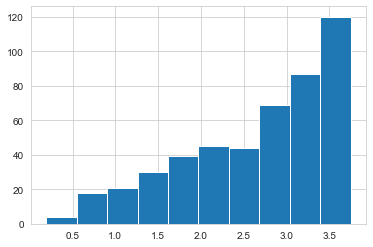

C:\Users\camil\AppData\Local\Temp/ipykernel_12008/970547286.py:3: RuntimeWarning: invalid value encountered in sqrt
  plt.hist(np.sqrt(y))


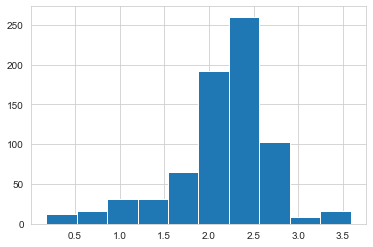

C:\Users\camil\AppData\Local\Temp/ipykernel_12008/970547286.py:5: RuntimeWarning: invalid value encountered in sqrt
  plt.hist(np.sqrt(z))


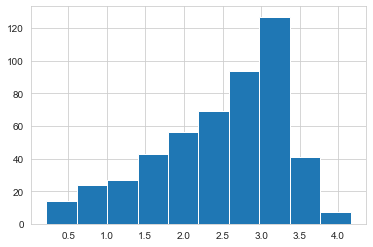

In [221]:
plt.hist(np.sqrt(x))
plt.show();
plt.hist(np.sqrt(y))
plt.show();
plt.hist(np.sqrt(z))
plt.show();

# visual ind- ts

In [222]:
def visualize(li_zone, color, config, save=False, path_=None, name_=None):
    #put xlabel into numbers for the ploting
    li_zoneid = [int(config.dico_zone_order[x]) for x in li_zone]
    #plt.yticks([0,1,2,3,4], ['Winter garden', 'Litter', 'Lower perch','Nestbox','Top floor'])
    plt.yticks([])
    plt.xticks([])
    #plt.title(str(d).split('T')[0], size=8)
    plt.plot(list(range(0,len(li_zone))),li_zoneid, linewidth=3, color=color)
    #li_hour = pd.date_range(start = d,  end = d+dt.timedelta(days=1), freq = 'H')
    #plt.xticks(li_hour , [str(i.hour)+'h' for i in li_hour], fontsize=5)                
    plt.yticks(fontsize=8)
    plt.ylim(0, 4.2) #always from WG to top tier
    plt.grid(False)
    plt.box(False)
    if save:
        plt.savefig(os.path.join(path_,name_+'.png'), format='png', bbox_inches='tight', transparent=True) #dpi=300, 
    plt.clf()
    plt.close("all") 
#small example
#li_Zone = df_ts['ts'].iloc[0]
#visualize(li_Zone, config)

for h,c in zip(li_vis_hen,li_vis_col):
    li_hl = df_3dspace[df_3dspace['h']==h]['HenID'].tolist()
    for hl in li_hl:
        li_Zone = df_ts[df_ts['henid_level']==hl]['ts'].values[0]
        visualize(li_zone=li_Zone, color=c, config=config, save=True, path_=path_extracted_data_visual, 
                  name_=hl.replace('/','-'))